In [1]:
import datetime
import rasterio as rs

def get_date(fl):
    
    year = fl.split('__')[-1].split('.')[0][11:15]
    month = fl.split('__')[-1].split('.')[0][15:17]
    day = fl.split('__')[-1].split('.')[0][17:19]
    
    return '%s-%s-%s'%(year,month,day)

def get_WaterYear(dt):
    
    strt = datetime.datetime(dt.year,10,1)
    nd = datetime.datetime(dt.year,12,31)
    
    if (dt >= strt) & (dt <= nd):
        return dt.year+1
    else:
        return dt.year
    
def DOWY(date):
    '''compute day of water year from a YYYY-MM-DD date string'''
    if date == 'None':
        return np.NaN
    else:
        year = int(date.split('-')[0])
        month = int(date.split('-')[1])
        day = int(date.split('-')[2])
        
        date = datetime.datetime(year,month,day)

        if date <= datetime.datetime(year,9,30):
            return (date - datetime.datetime(year - 1,10,1)).days
        else: 
            return (date - datetime.datetime(year,10,1)).days + 1
        
def get_dons(vals,dates=[]):
    '''Pull the date of no snow'''
    if np.nansum(vals) > 0:
        dons = dates[np.nanargmin(vals)] # return the first date that the pack hits 0
        return DOWY(str(dons.date()))
    else: return np.NaN
    
def get_peakSWE(vals):
    '''Pull the peak SWE value'''
    
    if np.nansum(vals) > 0:
        peakSWE = np.nanmax(vals)
        return peakSWE

    else:
        return np.NaN

def get_doPeakSWE(vals,dates=[]):
    '''Pull the date of peak SWE
    return a datetime object
    '''
    if np.nansum(vals) > 0:
        dops = dates[np.nanargmax(vals)] # return the first date that the pack maxes out
        return DOWY(str(dops.date()))
    
    else: return np.NaN

def savetiff(inarray,outfl,profile):
    '''Save a geotiff of an array using the file name and geospatial profile provided.'''
    with rs.open(outfl,'w',**profile) as ds:
        ds.write(inarray,1)

In [2]:
# generate a list of file names
files = pd.DataFrame()
files['name'] = glob.glob('./data/SNODAS_SWE/SnowWaterEquivalent/*/*.tif')
files['datetime'] = files.name.map(get_date)
files.index = pd.DatetimeIndex(files.datetime)
del files['datetime']
files['WaterYear'] = files.index.map(get_WaterYear)
files.sort_index(ascending=True,inplace=True)

In [12]:
def process_year(wy, files=[],output=False):
    '''
    Compute day of water year of peak swe, day of water year of no snow, peak SWE.
    
    Inputs:
    wy = water year
    files = file list
    output = boolean for output numpy arrays
    
    Outputs:
    Three rasters:
    - Day of water year of peak SWE
    - Day of water year of no snow
    - Peak SWE
    '''
    fileList = files.loc[files.WaterYear==wy] # extract the files necessary
    n = len(fileList) # number of files or raster stack depth
    dates = fileList.index

    # load a test file to get the array dimensions
    with rs.open(fileList.name[0]) as ds:
        j,k = ds.read(1).shape
        profile = ds.profile

    tmp = np.ndarray((n,j,k),dtype=np.float32) # preallocate the array
    tmp[:,:,:] = np.NaN # fill with NaNs

    i = 0
    for fl in fileList.name:

        with rs.open(fl) as ds:
            d = ds.read(1)

            jj,kk = d.shape
            if (jj != j) | (kk != k):
                print('Arrays are not the same shape, skipping slice %s'%i)
                del d
                i += 1
                continue
            else:
                dd = np.array(d,dtype = np.float32)
                del d
                dd[dd==-9999] = np.NaN
                tmp[i,:,:] = dd/1000. # pull the data into the stack and scale it
                i += 1

    # preallocate
    #dowy_PeakSWE = np.ndarray((j,k),dtype=np.float32)
    #dowy_PeakSWE[:,:] = np.NaN
    #dowy_DONS = dowy_PeakSWE.copy()
    #PeakSWE = dowy_PeakSWE.copy()

    # apply functions across the arrays
    dowy_PeakSWE = np.apply_along_axis(get_doPeakSWE,0,tmp,dates=dates)
    dowy_DONS = np.apply_along_axis(get_dons,0,tmp,dates=dates)
    PeakSWE = np.apply_along_axis(get_peakSWE,0,tmp)

    ndval = -99
    # make the NaN the no data value
    dowy_DONS[np.isnan(dowy_DONS)] = ndval
    dowy_PeakSWE[np.isnan(dowy_PeakSWE)] = ndval
    PeakSWE[np.isnan(PeakSWE)] = ndval

    # save the output
    profile['dtype'] = 'float64' # fix profile for the new arrays
    profile['nodata'] = ndval # fix the no data value

    outfl = './data/snodas_peakSWE_wy%s.tiff'%wy
    savetiff(PeakSWE,outfl,profile)

    outfl = './data/snodas_DOWYpeakSWE_wy%s.tiff'%wy
    savetiff(dowy_PeakSWE,outfl,profile)

    outfl = './data/snodas_DOWYnoSnow_wy%s.tiff'%wy
    savetiff(dowy_DONS,outfl,profile)
    
    if output:
        return dowy_DONS,dowy_PeakSWE,PeakSWE

## Test script

This appears to work!

In [5]:
dowy_DONS,dowy_PeakSWE,PeakSWE = process_year(2004, files=files, output = True)

Arrays are not the same shape, skipping slice 157


/home/tbarnhart/miniconda3/envs/py36/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


## Run across the whole time period

In [13]:
df = pd.DataFrame()
df['WaterYear'] = files.WaterYear.unique()

In [ ]:
df.WaterYear.apply(process_year,files=files,output=False)

Arrays are not the same shape, skipping slice 157


/home/tbarnhart/miniconda3/envs/py36/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Arrays are not the same shape, skipping slice 154


## Visualize Test Output

In [6]:
nd = -99
dowy_DONS[dowy_DONS == nd] = np.NaN
dowy_PeakSWE[dowy_PeakSWE == nd] = np.NaN
PeakSWE[PeakSWE == nd] = np. NaN

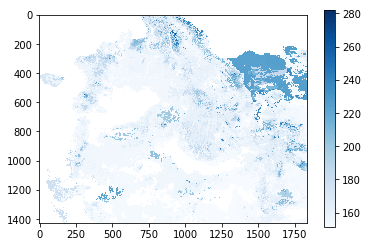

In [7]:
plt.imshow(dowy_PeakSWE,cmap='Blues')
plt.colorbar()

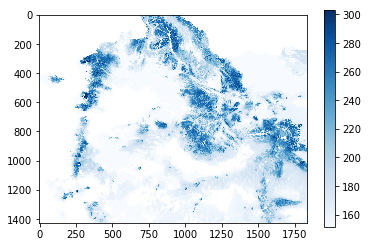

In [8]:
plt.imshow(dowy_DONS,cmap='Blues')
plt.colorbar()

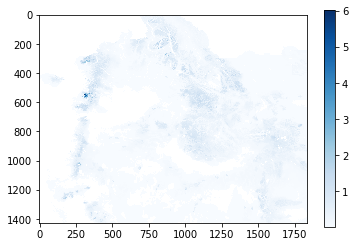

In [9]:
plt.imshow(PeakSWE,cmap='Blues')
plt.colorbar()

In [10]:
print(np.nanmean(dowy_PeakSWE))
print(np.nanmean(dowy_DONS))
print(np.nanmean(PeakSWE))

164.929814908
179.822541564
0.156354235991
